**Logistic Regression model**

The model aims to differentiate between individuals with Schizophrenia and healthy controls by analyzing EEG features. Logistic Regression is chosen due to its simplicity and effectiveness for binary classification tasks, where the goal is to predict two possible outcomes: Schizophrenia or not.

In [1]:
import numpy as np

In [2]:
# Load the data from drive
data_array = np.load('/content/drive/My Drive/data_array.npy')
label_array = np.load('/content/drive/My Drive/label_array.npy')
group_array = np.load('/content/drive/My Drive/group_array.npy')
features_array = np.load('/content/drive/My Drive/features_array.npy')

print(data_array.shape, label_array.shape, group_array.shape,features_array.shape)

(6843, 19, 1250) (6843,) (6843,) (6843, 551)


# ML model

In [3]:
!pip install scikit-learn

In [7]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.3 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
# Define classifier with class balancing
clf = LogisticRegression(class_weight='balanced', max_iter=500)

# Define Group K-Fold
gkf = GroupKFold(n_splits=5)

# Define pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', clf)
])

# Define hyperparameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],  # Different scalers
    'clf__C':  np.logspace(-3, 3, 10),  # Wider range of C values
    'clf__solver': ['liblinear', 'lbfgs']  # Different solvers for optimization
}

# Perform Grid Search with GroupKFold Cross-Validation
gscv = GridSearchCV(pipe, param_grid, cv=gkf, n_jobs=-1, verbose=1)

gscv.fit(features_array, label_array, groups=group_array)
best_model = gscv.best_estimator_

# Print best parameters and best score
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'clf__C': 0.021544346900318832, 'clf__solver': 'liblinear', 'scaler': MinMaxScaler()}
Best Score: 0.6124890199175328


# Classification report and Confusion matrix  

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60      3183
           1       0.65      0.59      0.62      3660

    accuracy                           0.61      6843
   macro avg       0.61      0.61      0.61      6843
weighted avg       0.61      0.61      0.61      6843



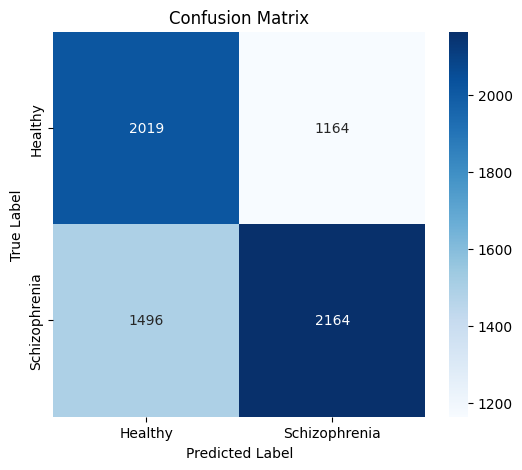

In [35]:
# Initialize arrays for storing results
y_true_all = []
y_pred_all = []

# Perform GroupKFold cross-validation manually with the best model
for train_idx, test_idx in gkf.split(features_array, label_array, groups=group_array):
    # Split data
    X_train, X_test = features_array[train_idx], features_array[test_idx]
    y_train, y_test = label_array[train_idx], label_array[test_idx]

    # Fit the best model on training data
    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)

    # Store true and predicted labels
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all))

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Schizophrenia"], yticklabels=["Healthy", "Schizophrenia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()